In [9]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from timeit import default_timer as dft
%matplotlib inline

In [10]:
def balanced_error_rate(y_true, y_test):
    
    conf = confusion_matrix(y_true, y_test)
    
    return 0.5 * (conf[0,1] / conf[0].sum()) + 0.5 * (conf[1,0] / conf[1].sum())

def error_metrics(y_true, y_test):
    
    print('BER: ', balanced_error_rate(y_true, y_test))
    print('F1: ', f1_score(y_true, y_test))

In [11]:
def load_data(data_name):
    '''data_name:  'arcene', 'dorothea', 'gisette', 'dexter', or 'madelon'. '''
    
    fp = '/home/james/anaconda3/data/' + data_name.upper() + '/'
    
    if data_name not in ['dorothea', 'dexter']:
        
        X_train = np.loadtxt(fp + data_name + '_train.data')
        y_train = np.loadtxt(fp + data_name + '_train.labels')
        X_test = np.loadtxt(fp + data_name + '_valid.data')
        y_test = np.loadtxt(fp + data_name + '_valid.labels')
        y_train = np.asanyarray((y_train + 1) // 2, dtype = 'i8')
        y_test = np.asanyarray((y_test + 1) // 2, dtype = 'i8')
        
    else:
        
        X_train = np.load(fp + data_name + '_train.npy')
        y_train = np.loadtxt(fp + data_name + '_train.labels')
        X_test = np.load(fp + data_name + '_valid.npy')
        y_test = np.loadtxt(fp + data_name + '_valid.labels')
        y_train = np.asanyarray((y_train + 1) // 2, dtype = 'i8')
        y_test = np.asanyarray((y_test + 1) // 2, dtype = 'i8')
        
        
    print(data_name.upper() + ' Data:')
    print('Training data info: ')
    print(X_train.shape[0], ' samples, ', X_train.shape[1], ' features.')
    print(int(y_train.sum()), ' positve samples, ', int(X_train.shape[0] - y_train.sum()), ' negative samples')
    print('-------------------------------')
    print('Test data info: ')
    print(X_test.shape[0], ' samples.')
    print(int(y_test.sum()), ' positve samples, ', int(X_test.shape[0] - y_test.sum()), ' negative samples')
    return X_train, y_train, X_test, y_test

In [20]:
class Particle(object):
    
    def __init__(self, tot_feat, c_s='def'):
        
        if c_s == 'def':
            
            choice_size = np.random.choice(np.arange(1,tot_feat))
            
        else:
            
            choice_size = np.random.choice(np.arange(1,c_s))
            
        self.locs = np.sort(np.random.choice(np.arange(tot_feat),
                                             size=choice_size,
                                             replace=False))
        self.p = np.zeros(tot_feat, dtype='i8')
        self.v = np.random.uniform(low=-7, high=7, size=tot_feat)
        self.p[self.locs] = np.ones(len(self.locs), dtype='i8')
        self.num_feats = int(self.p.sum())
        self.p_best = np.copy(self.p)
        self.ber_best = 1
        self.ber = None
        self.f1 = None
        self.auc = None
        
    def fit_clf(self, clf, size_reg,  X_train, y_train):
        
        clf.fit(X_train[:,self.locs], y_train)
        self.ber = (balanced_error_rate(y_test, clf.predict(X_test[:,self.locs])) +
                   0 * (np.copy(self.num_feats) / len(self.p)))
        self.f1 = f1_score(y_test, clf.predict(X_test[:,self.locs]))
        self.auc = roc_auc_score(y_test, clf.predict(X_test[:,self.locs]))
        
        if self.ber + 0 * (self.num_feats / len(self.p)) < self.ber_best:
            
            self.p_best = np.copy(self.p)
            self.ber_best = np.copy(self.ber) + size_reg * (np.copy(self.num_feats) / len(self.p))
            
    def update_locs(self):
        
        self.locs = np.where(self.p == 1)[0]
        self.num_feats = int(self.p.sum())
        
def update_velocity(part, g_best_pos):
    
    r1, r2 = np.random.uniform(), np.random.uniform()
    part.v = np.clip(part.v + (3 * r1 * (part.p_best - part.p))  + (2 * r2 * (g_best_pos - part.p)),
                     -10, 10)
    
def logistic(v):
    
    return (1 + np.exp(-v))**(-1)

def update_position(part):
    
    S = logistic(part.v)
    r = np.random.uniform()
    new_p = np.asanyarray(S >= r, dtype='i8')
    
    if new_p.sum() != 0:
        
        part.p = new_p
        
    part.update_locs()
    

def run_pso(swarm_size, num_iter, size_reg, clf, itr=1):
    
    print('Initializing the swarm....')
    
    swarm = []

    for k in range(swarm_size):
    
        swarm.append(Particle(X_train.shape[1]))
    
    swarm[0].fit_clf(clf, size_reg, X_train, y_train)

    g_best_loc = 0
    g_best_pos = np.copy(swarm[0].p)
    g_best_score = np.copy(swarm[0].ber) + size_reg * (np.copy(swarm[0].num_feats) / len(swarm[0].p))

    for k in range(1,len(swarm)):
    
        swarm[k].fit_clf(clf, size_reg,  X_train, y_train)
    
        if g_best_score > swarm[k].ber + size_reg * (swarm[k].num_feats / len(swarm[k].p)):
        
            g_best_loc = k
            g_best_pos = np.copy(swarm[k].p)
            g_best_score = np.copy(swarm[k].ber) + size_reg * (np.copy(swarm[k].num_feats) / len(swarm[k].p))
            
    print('Iteration ', itr, ' Initial Best (BER, f1, num_feats, score): (', swarm[g_best_loc].ber,
                  ', ', swarm[g_best_loc].f1, ', ', swarm[g_best_loc].num_feats,', ', g_best_score, ')')

    for iteration in tqdm(range(num_iter)):
    
        for k in range(len(swarm)):
        
            update_velocity(swarm[k], g_best_pos)
            update_position(swarm[k])
            swarm[k].fit_clf(clf, size_reg, X_train, y_train)
    
        for k in range(len(swarm)):
    
            if g_best_score > swarm[k].ber + size_reg * (swarm[k].num_feats / len(swarm[k].p)):
            
                g_best_loc = k
                g_best_pos = np.copy(swarm[k].p)
                g_best_score = np.copy(swarm[k].ber) + size_reg * (np.copy(swarm[k].num_feats) / len(swarm[k].p))
                print(' Iteration ', itr, ' Current Best (BER, f1, num_feats, score): (', swarm[k].ber,
                  ', ', swarm[k].f1, ', ', swarm[k].num_feats,', ', g_best_score, ')')
                
        b_feat = int(min(len(swarm[0].p), 2 * swarm[g_best_loc].num_feats))
        rand_ind = np.random.choice(np.arange(swarm_size, dtype='i8'), replace=False, size=15)
        
        for ind in rand_ind:
            
            if ind != g_best_loc:
                
                swarm[ind] = Particle(X_train.shape[1], b_feat)
                swarm[ind].fit_clf(clf, size_reg, X_train, y_train)
            
    best_part = Particle(X_train.shape[-1])
    best_part.p = g_best_pos
    best_part.update_locs()
    best_part.fit_clf(clf, size_reg, X_train, y_train)
    
    return best_part

In [86]:
from sklearn import preprocessing
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.linear_model import LogisticRegression
import math

def train(x_train,y_train):
    logreg = LogisticRegression(class_weight='balanced', C=0.0001)
    logreg.fit(x_train, y_train)
    return logreg

def get_ber(y_pred, y_test):
    ber = (np.mean(y_pred[y_test == 0] != 0 )+np.mean(y_pred[y_test == 1] != 1 ))/2
    return ber

def get_metrics(x_test, y_test, logreg):
    print('Accuracy: ', logreg.score(x_test, y_test))
    y_pred = logreg.predict(x_test)
    print('BER:', get_ber(y_pred, y_test))
    print(sklearn.metrics.classification_report(y_pred, y_test))
    print('Confusion Matrix\n', sklearn.metrics.confusion_matrix(y_pred, y_test))
    
    
def get_cost(x, y, x_test, y_test):
    #Train or test TODO: decide
    #mean = x.mean(axis=0) 
    #std = x.std(axis=0)+1e-6
    #x_n = (x - mean) / std
    #logreg = train(x_n, y)
    logreg = train(x, y)
    
    #x_test_n = (x_test - mean) / std
    #y_pred = logreg.predict(x_test_n)
    y_pred = logreg.predict(x_test)
    
    n = x_test.shape[0]
    #aic = n*np.log(sum((y_pred-y_test)*(y_pred-y_test))/n)+2*(x_test.shape[1]+1)
    #AIC=n∗ln(SSEn)+2k
    ber = get_ber(y_pred, y_test)
    
    return ber


def get_rcost(x_train, y_train, x_test, y_test, ind):
    cost =  get_cost(x_train[:,ind==1],y_train, x_test[:, ind==1], y_test)
    
    #return cost+0.001*np.mean(ind)
    return cost+0.0001*np.sum(ind)
    #return cost

nbr=6

def rand_init(x_train, y_train, n=50000, seed=123456):
    size = x_train.shape[1]
    ind = np.zeros(size)
    a = np.arange(size)
    np.random.shuffle(a)
    ind[a[:n]] = 1
    return ind

def get_nbr(ind, code=1, nbr=2, seed=123456):
    #print("Code", code, "bits", nbr)
    if code == 1:
        #This part looks for random 1/2 position swap
        return rand_swap_nbr(ind, nbr, seed=123456)
    elif code == 2:
        #This part allows grow/shrink
        return rand_any_nbr(ind, nbr, seed=123456)
    elif code == 3:
        #This part allows grow/shrink
        return rand_mutate_nbr(ind, nbr, seed=123456)
    else:
        print('Wrong code')
    return ind



def get_rand_nbr(ind, code=1, nbr=30, bits=2):
    #print("code", code, "nbr",nbr)
    ind_nbr = np.zeros((nbr, ind.shape[0]))
    for i in range(0, nbr):
        ind_nbr[i] = get_nbr(ind, code, nbr=bits)
      
    return ind_nbr

def rand_swap_nbr(ind, nbr=2, seed=123456):
    '''
    ind --> is a 0/1 array. Neighbours of this array would be maximum of any two positions changed
    '''
    ind_pos, = np.where(ind==1)
    ind_neg, = np.where(ind==0)
    
    
    pos = np.random.choice(ind_pos, nbr/2, replace=False)
    ind[pos] = 0
     
    neg = np.random.choice(ind_neg, nbr/2, replace=False)
    ind[neg] = 1
    return ind


def rand_any_nbr(ind, nbr=2, seed=123456):
    '''
    ind --> is a 0/1 array. Neighbours of this array would be maximum of any two positions changed
    '''
    ind_pos, = np.where(ind==1)
    ind_neg, = np.where(ind==0)
        
    ch = np.random.uniform(0,2)
    if round(ch) == 0:
        #change some 1 to 0
        n = round(np.random.uniform(1,nbr))
        ind[np.random.choice(ind_pos, n)] = 0
    elif round(ch) == 1:
        n1 = round(np.random.uniform(1,nbr))
        ind[np.random.choice(ind_pos, n1)] = 0
        n2 = round(np.random.uniform(1,nbr))
        ind[np.random.choice(ind_neg, n2)] = 1
        
    else:
        n = round(np.random.uniform(1,nbr))
        ind[np.random.choice(ind_neg, n)] = 1
    
    return ind

def rand_mutate_nbr(ind, nbr=2, seed=123456):
    '''
    ind --> is a 0/1 array. Neighbours of this array would be maximum of any two positions changed
    '''
        
    D = ind.shape[0]
    
    #new neighbor
    ind1 = np.zeros(D)
    a = np.arange(D)
    np.random.shuffle(a)
    start_n = np.random.randint(D)
    ind1[a[:start_n]] = 1
    
    #Mutate
    n = np.random.randint(2, size=D)
    n_orig, = np.where(n==1)
    n_new, = np.where(n==0)
    
    ind2 = np.zeros(D)
    ind2[n_orig] = ind[n_orig]
    ind2[n_new] = ind1[n_new]
    
    return ind2

def rand_mutate_nbr1(ind, nbr=2, seed=123456):
    '''
    ind --> is a 0/1 array. Neighbours of this array would be maximum of any two positions changed
    '''
        
    D = ind.shape[0]
    a = np.arange(D)
    rand_ind = np.random.choice(a, nbr)
    
    
    #Generate a 0/1 for rand choice
    ind_phi = np.random.randint(2, size=nbr)
    phi_pos, = np.where(ind_phi==1)
    phi_neg, = np.where(ind_phi==0)
    
    #print(phi_pos, phi_neg)
    #print(rand_ind, rand_ind[phi_pos], rand_ind[phi_neg])
    ind[rand_ind[phi_pos]]=1
    ind[rand_ind[phi_neg]]=0
    '''
    j = 0
    for i in rand_ind:
        if ind_phi[j] == 0:
            if ind[i] == 1:
                ind[i] = 0 
                #flip the selection
        else:
            if ind[i] == 0:
                ind[i] = 1 
                #flip the selection
        j=j+1
    '''
    return ind


import os
import errno

def  save_res(save_path='results', file='Temp', ind=[], ber=0.0,c_a=[]):

    try:
        os.makedirs (save_path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
        

    np.savez_compressed(os.path.join(save_path, file),
                        ind = ind, ber=ber, cost_arr=c_a)        


np.random.seed(123456)

def initial_temp():
    return 1.0


def acceptance_probability(old_cost, new_cost, temp):
    return np.exp((old_cost - new_cost) / temp)


def accept_proposal(current, proposal, temperature):
    
    if (proposal < current):
        return 1
    if (temperature == 0.0):
        return 0
    prob = np.exp(-(proposal - current) / temperature)
    return np.random.uniform() < prob


def reduce_temp(T, repetitions, code=1):
    alpha = 0.9
    if code == 1:
        return T*alpha
    elif code == 2:
        T=T/math.log(repetitions+2,2)
        #print('New temp:',T)
        return T
    else: 
        T = T - 0.1
        return T

    
def run_SA(x_train, y_train, x_test, y_test, max_iter=1000, nbr=30, bits=4, nbr_code=3, temp_code=2):

    tol = 0.0001
    #Initialize
    cost_arr = np.zeros((max_iter*2,2))
    start_n = np.random.randint(x_train.shape[1])
    ind = rand_init(x_train, y_train, start_n, seed=123456)
    #cost = get_rcost(x_train, y_train, x_test, y_test, ind)
    cost = get_cost(x_train[:,ind==1], y_train, x_test[:,ind==1], y_test)
    print('Initial BER: ',cost)
    cost_arr[0,0] = cost
    cost_arr[0,1] = sum(ind)
    #Move
    ii = 0
    T = initial_temp( )
    T_min = 0.0001
    
    while ii < max_iter and T > T_min:
        j = 0
        while j <= min(100, max_iter):
            ind_nbr = get_rand_nbr(ind, nbr_code, nbr=nbr, bits=4)
        
            ind1 = ind_nbr[0]
            #cost1 = get_rcost(x_train,y_train, x_test, y_test, ind1)
            cost1 = get_cost(x_train[:,ind1==1],y_train, x_test[:,ind1==1], y_test)
            for i in range(1, nbr):   
                #cost_i = get_rcost(x_train,y_train, x_test, y_test, ind_nbr[i])
                cost_i = get_cost(x_train[:, ind_nbr[i]==1],y_train, x_test[:, ind_nbr[i]==1], y_test )
                if cost_i < cost1:
                    cost1 = cost_i
                    ind1 = ind_nbr[i]
            
            #ap = acceptance_probability(cost, cost1, T)
            #if ap > np.random.uniform():
            ap = accept_proposal(cost, cost1, T)
            if ap == 1:
                ind = ind1
                cost = cost1
                #print(cost,end=' ')
                #print('i',ii, 'j',j)
                #print(cost, ii, end=' ')
            j += 1
           
            cost_arr[ii,0] = cost
            cost_arr[ii,1] = sum(ind)
            ii = ii+1
            print(".",end='')
            if ii%100 == 0:
                #print(sum(ind), cost)
                print(cost, ii)
            
        T = reduce_temp(T, ii, temp_code)
        #print(i)
    
    print('Features selected:', sum(ind))
    print('Final cost', cost)
    
    print('Iterations run', ii,'\nFinal cost ',cost)
    logreg = train(x_train[:,ind==1], y_train)
    #get_test_acc(x_test[:,ind==1], y_test, logreg)
    print(logreg.score(x_test[:,ind==1], y_test))
    
    return ind, cost, cost_arr


def run_HC(x_train, y_train, x_test, y_test, max_iter=500, restart_iter=200, nbr=3, bits=6, nbr_code=3):

    tol = 0.0001

    #Initialize
    c_a = np.zeros((max_iter,2))
    start_n = np.random.randint(x_train.shape[1])
    ind = rand_init(x_train, y_train, start_n, seed=123456)
    print(x_train[:,ind==1].shape)

    #cost = get_rcost(x_train, y_train, x_test, y_test, ind)
    cost = get_cost(x_train[:, ind==1], y_train, x_test[:, ind==1], y_test)
    print('Initial Cost: ',cost)
    c_a[0,0] = cost
    c_a[0,1] = sum(ind)

    #Move
    update = 0
    for i in range(0, max_iter):
        #Get random neighbors
        ind_nbr = get_rand_nbr(ind, nbr_code, nbr=nbr, bits=bits)
    
        ind1 = ind_nbr[0]
        #cost1 = get_rcost(x_train, y_train, x_test, y_test, ind1)
        cost1 = get_cost(x_train[:, ind1==1], y_train, x_test[:, ind1==1], y_test)
    
        for ii in range(1, nbr):   
            #cost_i = get_rcost(x_train,y_train, x_test, y_test, ind_nbr[ii])
            cost_i = get_cost(x_train[:,ind_nbr[ii]==1],y_train, x_test[:,ind_nbr[ii]==1], y_test)
            if cost_i < cost1:
                cost1 = cost_i
                ind1 = ind_nbr[ii]
        #print(acc1)
        if cost1 <  cost:
            ind = ind1
            cost = cost1
            update += 1
            
            
            print(cost,update,end=' ')
        else:
            print('.',end='')

        c_a[i,0] = cost
        c_a[i,1] = sum(ind)
        if i%100 == 0:
            print('\n')
            print(sum(ind))
            #print(ind[:50])
            print(cost)
        
        if i+1% restart_iter == 0:
            if update == 0:
                print('Restarting.......')
                start_n = np.random.randint(x_train.shape[1])
                ind = rand_init(x_train, y_train, n=start_n, seed=123456)
                cost = get_cost(x_train[:,ind==1],y_train, x_test[:, ind==1], y_test)
                init_cost = cost
                update = 0
                c_a[i,0] = cost
                c_a[i,1] = sum(ind)
        
        #print(i)
    print('Features selected:', sum(ind))
    print('Final cost', cost)
    print(ind[:50])

    return ind, cost, c_a

In [72]:
from __future__ import division
import random
from operator import attrgetter



def balanced_error_rate(y_true, y_test):  
    conf = confusion_matrix(y_true, y_test)
    #print conf
    return 0.5 * (conf[0,1] / conf[0].sum()) + 0.5 * (conf[1,0] / conf[1].sum())
def full_feature(train_data,train_label,valid_data,valid_label):
    models = []
    models.append(('Logistic Regression', LogisticRegression(C=0.0001,class_weight='balanced')))
    for name, model in models:
        model.fit(train_data,train_label)
        valid_accuracy = accuracy_score(valid_label, model.predict(valid_data))
        #print valid_accuracy
        #print valid_label
        #print model.predict(valid_data_reduced)
        BER = balanced_error_rate(valid_label,model.predict(valid_data))
        #print BER
        fitness = 1.0/BER
    print('Full features BER')
    print(BER)
    return BER
class individual:
    def __init__(self,dim,train_data, train_label,valid_data,valid_label):
        # every invidual is a vector, with the same dimension as the dataset
        # Every dimension receive value 1 if that feature is used and 0 otherwise
        # ind: vector contains 0,1 value
        # dim: dimension (number of features)
        # BER: balance error rate
        # Probability: probability to choose this individual
        
        self.ind = self.create_individual(dim)       
        self.fitness,self.BER,self.valid_accuracy = self.fitness_evaluation(self.ind,
                                                train_data, train_label,valid_data,valid_label,dim)
        self.probability = 0.0
        self.dim = dim
    def create_individual(self,dim):
        choice_size = np.random.choice(np.arange(1,dim))
        #on_position is position that have value 1, mean the features is chosen
        on_position = np.sort(np.random.choice(np.arange(dim),size=choice_size,replace=False))
        individual = np.zeros(dim, dtype='i8')
        individual[on_position] = np.ones(len(on_position), dtype='i8')
        return individual
    def fitness_evaluation(self,individual, train_data,train_label,valid_data,valid_label,dim):
        models = []
        models.append(('Logistic Regression', LogisticRegression(C=0.0001,class_weight='balanced')))
        fil = np.nonzero(individual)
        train_data_reduced = train_data[:,fil[0]]
        valid_data_reduced = valid_data[:,fil[0]]
        for name, model in models:
            model.fit(train_data_reduced, train_label)
            valid_accuracy = accuracy_score(valid_label, model.predict(valid_data_reduced))
            #print valid_accuracy
            #print valid_label
            #print model.predict(valid_data_reduced)
            BER = balanced_error_rate(valid_label,model.predict(valid_data_reduced))
            #print BER
            fitness = 1.0/(BER +  0.001 * sum(self.ind)/dim)
        return fitness,BER,valid_accuracy
    def update_probability(self,total_fitness):
        self.probability = self.fitness / total_fitness
class population:
    def __init__(self,population_size,dim,train_data,train_label,valid_data,valid_label):
        self.pop = self.create_population(population_size,dim,train_data,train_label,valid_data,valid_label)
        self.total_fitness = self.cal_total_fitness(self.pop)
        self.population_size = population_size
    def cal_total_fitness(self,popul):
        total_fitness = 0.0
        for individual in popul: 
            total_fitness += individual.fitness
        return total_fitness
    def create_population(self,population_size,dim,train_data,train_label,valid_data,valid_label):
        pop = []
        # no_individual is the number of individual
        # dim is the dimension of individual
        for i in range(population_size):
            indi = individual(dim,train_data,train_label,valid_data,valid_label)
            pop.append(indi)
        return pop  
    def sort_fitness(self):
        self.pop.sort(key=attrgetter('fitness'),reverse=True)  
def Roulette_Wheel_Selection(a_popu):
    # Randomly select an individual to be a father/mother for next generation
    # Chosing base on individual fitness, the one has higher fitness has highest probability to be chosen
    total = 0.0
    random_number = random.random()
    #print random_number
    for inv in a_popu.pop:
        total += inv.probability
        if random_number < total:
            return inv
def evaluation(a_population,train_data,train_label,valid_data,valid_label):
    for indi in a_population.pop:
        indi.fitness,indi.BER,indi.valid_accuracy = indi.fitness_evaluation(indi.ind ,
                                                train_data,train_label,valid_data,valid_label, indi.dim)
    a_population.total_fitness = a_population.cal_total_fitness(a_population.pop) 
    for indi in a_population.pop:
        indi.update_probability(a_population.total_fitness)
def selection(a_population):
    sel = []
    # Select M-1 individuals
    for i in range(a_population.population_size-1):
        sel.append(Roulette_Wheel_Selection(a_population))
    for i in range(1,a_population.population_size):
        a_population.pop[i] = sel[i-1]
def cross_over(a_population,train_data,train_label,valid_data,valid_label,cross_over_probability = 1.0):
    # Chosen a list of parents for next generation
    # Shuffle the population, except the first one - the elite, which has the highest fitness
    random.shuffle(a_population.pop[1:])
    parent_pairs = zip(*(iter(a_population.pop),) * 2)
    childs = []
    for parent in parent_pairs: 
        # Create a random number from (0,1)
        random_number = random.random()
        # if this random number is smaller than cross_over_probability then we do cross over: 
        if random_number < cross_over_probability:
            #print parent[0].dim
            son = individual(parent[0].dim,train_data,train_label,valid_data,valid_label)
            daughter = individual(parent[0].dim,train_data,train_label,valid_data,valid_label)
            cross_over_point = random.randint(0,parent[0].dim)
            for i in range(cross_over_point):
                son.ind[i] = parent[0].ind[i]
                daughter.ind[i] = parent[1].ind[i]
            for i in range(cross_over_point,parent[0].dim):
                son.ind[i] = parent[1].ind[i]
                daughter.ind[i] = parent[0].ind[i]
            # Check if the new child is all 0, then make it the same as parent
            if not np.any(son):
                son = parent[0]
            if not np.any(daughter):
                daughter = parent[1]
        else:
            son = parent[0]
            daughter = parent[1]
        childs.append(son)
        childs.append(daughter)
    for i in range(1,len(a_population.pop)):
        a_population.pop[i] = childs[i-1]
def mutation(a_population,mutation_probability = 0.001):
    for indi in a_population.pop[1:]:
        z = np.copy(indi)
        # Create a random number from (0,1)
        for i in range(len(indi.ind)):
            random_number = random.random()
            # if this random number is smaller than mutation_probability then we do mutation: 
            if random_number < mutation_probability:
                indi.ind[i] = 1 - indi.ind[i]
        # Check if the result of mutation is all 0, then make it the same as before
        if not np.any(indi):
            indi = z
def GA(dim, num_iter, train_data, train_label,valid_data,valid_label):
    
    # Create population
    population_size = 101
    m = population(population_size,dim,train_data,train_label,valid_data,valid_label)
    evaluation(m,train_data,train_label,valid_data,valid_label)
    m.sort_fitness()
    for count in range(num_iter):
        selection(m)
        cross_over(m,train_data,train_label,valid_data,valid_label)
        mutation(m)
        evaluation(m,train_data,train_label,valid_data,valid_label)
        m.sort_fitness()
    print('Best Result: BER, number of feature ')
    print(m.pop[0].BER, sum(m.pop[0].ind))
    return m.pop[0].BER, sum(m.pop[0].ind)

def GA_multi(num,dim,train_data, train_label,valid_data,valid_label,name_dataset):
    print('-----------------------------')
    print('Dataset ', name_dataset)
    full_feature(train_data,train_label,valid_data,valid_label)
    for i in range(num):
        print('Experiment', i + 1)
        BER_array =[]
        num_feature_array = []
        BER, num_feature = GA(dim,train_data,train_label, valid_data,valid_label)
        BER_array.append(BER)
        num_feature_array.append(num_feature)
        BER_mean = np.mean(BER_array)
        num_feature_mean = np.mean(num_feature_array)
        print('*******')
    print('BER mean', BER_mean)
    print('num feature mean', num_feature_mean)


In [100]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import timeit
np.random.seed(920412)

#This controls number of iterations
epoch=10
#This controls the amount of features from RF
numoffeature=90


def init(k):
    h=[]
    clf = RandomForestClassifier(n_estimators=500,
                             criterion='gini', max_depth=10,  min_weight_fraction_leaf=0.0,
                             max_features='auto' )
    clf.fit(train_data, train_label)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(k):
        h.append(int(indices[f]))

    return h

def balanced_error_rate(y_true, y_test):
    conf = confusion_matrix(y_true, y_test)
    return 1-(0.5 * ((conf[0,1]*1.0) /conf[0].sum()) + 0.5 * ((1.0*conf[1,0]) / conf[1].sum()))

def eval(h):
    lr = LogisticRegression(C=1e-4,class_weight='balanced',max_iter=500)
    lr.fit(train_data[:,h], train_label)
    score = balanced_error_rate( valid_label ,lr.predict(valid_data[:,h]))
    return score

def update(p, epoch):
    start=timeit.default_timer()
    h=list()
    addedlist=[]
    oldlist=[]

    oldscore=-1
    highest=0.0
    best=[]

    k=100
    while(k>=numoffeature): #0
        for i in range(epoch): #1
            start2=timeit.default_timer() #2
            fvector=init(k) #2
            end2=timeit.default_timer() #2

            while len(fvector)<300: #2 
                #print "len(fvector): ",len(fvector)#3
                if np.random.random()<p: #3

                    key=np.random.multinomial(1, features / features.sum()).argmax() #4
                    while(key in fvector): #4
                        #print "while multi"
                        key=np.random.multinomial(1, features / features.sum()).argmax() #5

                else: #3

                    key=np.random.randint(281,500,size=1)[0] #4
                    while (key in fvector): #4
                        key=np.random.randint(281,500,size=1)[0] #5

                fvector.append(key) #3
                addedlist.append(key) #3

            score=eval(fvector)
            if oldscore is not -1: #2
                added=list(set(addedlist)-set(oldlist)) #3
                removed=list(set(oldlist)-set(addedlist))#3
                if score>oldscore: #3
                    if score>highest: #4
                        #print ">switch: ","score: ",score,"highest: ",highest #5
                        highest=score #5
                        best=fvector #5
                    for item in added: #4
                        features[item]+=1 #5
                    for item in removed: #4
                        if features[item]>0: #5
                            features[item]-=1 #6
                else: #3
                    if score>highest: #4
                        highest=score #5
                        best=fvector #5

                    for item in removed: #4
                        features[item]+=1 #5
                    for item in added: #4
                        if features[item]>0: #5
                            features[item]-=1 #6
            oldscore=score #2
            print("k: ",k, "Epoch: ",i, "current: ", eval(fvector),
              "oldscore: ",oldscore,"highest: ",highest,"initialize time:",end2-start2)
        # Reduce amount of Feature from RF by 10
        k-=10

def loadARCENE():
    training_file="ARCENE/arcene_train.data"
    training_label="ARCENE/arcene_train.labels"
    valid_file="ARCENE/arcene_valid.data"
    valid_label="ARCENE/arcene_valid.labels"
    train_data = np.loadtxt(training_file)
    train_label = np.loadtxt(training_label)
    valid_data = np.loadtxt(valid_file)
    valid_label = np.loadtxt(valid_label)
    return train_data,train_label,valid_data,valid_label

def loadDOROTHEA():
    train_data = np.load("DOROTHEA/train_array.npy")
    train_label = np.loadtxt("DOROTHEA/dorothea_train.labels")
    valid_data = np.load("DOROTHEA/test_array.npy")
    valid_label = np.loadtxt("DOROTHEA/dorothea_valid.labels")
    return train_data,train_label,valid_data,valid_label


def loadDEXTER():
    train_data = np.load("DEXTER/dexter_train.npy")
    train_label = np.loadtxt("DEXTER/dexter_train.labels")
    valid_data = np.load("DEXTER/dexter_valid.npy")
    valid_label = np.loadtxt("DEXTER/dexter_valid.labels")




In [73]:
# Time test on Arcene

X_train, y_train, X_test, y_test = load_data('arcene')
clf = LogisticRegression(C=0.0001, class_weight='balanced')


# SA
start = dft()
run_SA(X_train, y_train, X_test, y_test, max_iter=100, nbr=40, bits=4, nbr_code=3, temp_code=2)
sa_time_a = dft() - start

# HC 
start = dft()
run_HC(X_train, y_train, X_test, y_test, max_iter=100, restart_iter=200, nbr=40, bits=40, nbr_code=3)
hc_time_a = dft() - start

# GA
start = dft()
GA(X_train.shape[1], 100, X_train, y_train, X_test, y_test)
ga_time_a = dft() - start

# PSO
start = dft()
run_pso(150, 100, 0.01, clf)
pso_time_a = dft() - start

ARCENE Data:
Training data info: 
100  samples,  10000  features.
44  positve samples,  56  negative samples
-------------------------------
Test data info: 
100  samples.
44  positve samples,  56  negative samples
Initial BER:  0.155844155844
....................................................................................................0.121753246753 100
.Features selected: 1739.0
Final cost 0.124188311688
Iterations run 101 
Final cost  0.124188311688
0.88
(100, 8917)
Initial Cost:  0.167207792208
0.153409090909 1 

4874.0
0.153409090909
0.126623376623 2 0.112824675325 3 ....0.11038961039 4 ......................0.107954545455 5 ...0.099025974026 6 .....................................................0.0876623376623 7 ...........Features selected: 745.0
Final cost 0.0876623376623
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.

 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.00892857142857 ,  0.988764044944 ,  391 ,  0.00931957142857 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.00892857142857 ,  0.988764044944 ,  386 ,  0.00931457142857 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.00892857142857 ,  0.988764044944 ,  385 ,  0.00931357142857 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.00892857142857 ,  0.988764044944 ,  369 ,  0.00929757142857 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.00892857142857 ,  0.988764044944 ,  352 ,  0.00928057142857 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.00892857142857 ,  0.988764044944 ,  351 ,  0.00927957142857 )



In [101]:
train_data,train_label,valid_data,valid_label=load_data('arcene')
start = dft()
features=np.ones(train_data.shape[1])
update(0.85, 100)
tb_time_a = dft() - start()

train_data,train_label,valid_data,valid_label=load_data('dexter')
start = dft()
features=np.ones(train_data.shape[1])
update(0.85, 100)
tb_time_dx = dft() - start()

train_data,train_label,valid_data,valid_label=load_data('dorothea')
start = dft()
features=np.ones(train_data.shape[1])
update(0.85, 100)
tb_time_d = dft() - start()

ARCENE Data:
Training data info: 
100  samples,  10000  features.
44  positve samples,  56  negative samples
-------------------------------
Test data info: 
100  samples.
44  positve samples,  56  negative samples
k:  100 Epoch:  0 current:  0.785714285714 oldscore:  0.785714285714 highest:  0.0 initialize time: 0.8655324569990626
k:  100 Epoch:  1 current:  0.747564935065 oldscore:  0.747564935065 highest:  0.747564935065 initialize time: 0.8694560189978802
k:  100 Epoch:  2 current:  0.788149350649 oldscore:  0.788149350649 highest:  0.788149350649 initialize time: 0.8593421149998903
k:  100 Epoch:  3 current:  0.785714285714 oldscore:  0.785714285714 highest:  0.788149350649 initialize time: 0.8541306990009616
k:  100 Epoch:  4 current:  0.747564935065 oldscore:  0.747564935065 highest:  0.788149350649 initialize time: 0.8476683919943753
k:  100 Epoch:  5 current:  0.806006493506 oldscore:  0.806006493506 highest:  0.806006493506 initialize time: 0.8565831980013172
k:  100 Epoch:  

k:  100 Epoch:  62 current:  0.774350649351 oldscore:  0.774350649351 highest:  0.828733766234 initialize time: 0.8529958759972942
k:  100 Epoch:  63 current:  0.803571428571 oldscore:  0.803571428571 highest:  0.828733766234 initialize time: 0.8575503269967157
k:  100 Epoch:  64 current:  0.788149350649 oldscore:  0.788149350649 highest:  0.828733766234 initialize time: 0.8574928599991836
k:  100 Epoch:  65 current:  0.789772727273 oldscore:  0.789772727273 highest:  0.828733766234 initialize time: 0.861298331998114
k:  100 Epoch:  66 current:  0.788149350649 oldscore:  0.788149350649 highest:  0.828733766234 initialize time: 0.8578569259989308
k:  100 Epoch:  67 current:  0.806006493506 oldscore:  0.806006493506 highest:  0.828733766234 initialize time: 0.8774801850013318
k:  100 Epoch:  68 current:  0.770292207792 oldscore:  0.770292207792 highest:  0.828733766234 initialize time: 0.8591143510057009
k:  100 Epoch:  69 current:  0.806006493506 oldscore:  0.806006493506 highest:  0.82

KeyboardInterrupt: 

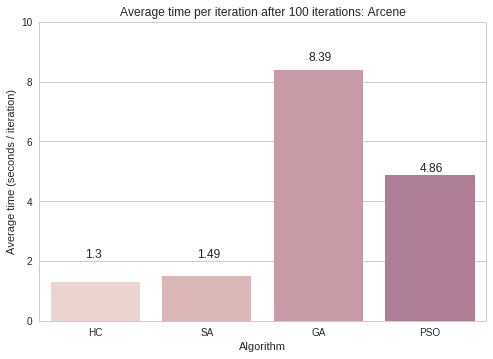

In [80]:
times = [hc_time_a / 100, sa_time_a/100, ga_time_a/100, pso_time_a/100]

g = sns.barplot(x=['HC', 'SA', 'GA', 'PSO'],y=times,
                palette=sns.cubehelix_palette(8))
plt.title('Average time per iteration after 100 iterations: Arcene')
plt.xlabel('Algorithm')
plt.ylabel('Average time (seconds / iteration)')
plt.ylim((0, 10))
g.text(-0.09, 2.1, str(round(times[0],2)))
g.text(1-0.09, 2.1, str(round(times[1],2)))
g.text(2-0.09, 8.7, str(round(times[2],2)))
g.text(3-0.09, 5, str(round(times[3],2)))

In [87]:
# Time test on Dexter

X_train, y_train, X_test, y_test = load_data('dexter')
clf = LogisticRegression(C=0.0001, class_weight='balanced')


# SA
start = dft()
run_SA(X_train, y_train, X_test, y_test, max_iter=100, nbr=40, bits=4, nbr_code=3, temp_code=2)
sa_time_dx = dft() - start

# HC 
start = dft()
run_HC(X_train, y_train, X_test, y_test, max_iter=100, restart_iter=200, nbr=40, bits=40, nbr_code=3)
hc_time_dx = dft() - start

# GA
start = dft()
GA(X_train.shape[1], 100, X_train, y_train, X_test, y_test)
ga_time_dx = dft() - start

# PSO
start = dft()
run_pso(150, 100, 0.01, clf)
pso_time_dx = dft() - start

DEXTER Data:
Training data info: 
300  samples,  20000  features.
150  positve samples,  150  negative samples
-------------------------------
Test data info: 
300  samples.
150  positve samples,  150  negative samples
Initial BER:  0.136666666667
....................................................................................................0.05 100
.Features selected: 15037.0
Final cost 0.0433333333333
Iterations run 101 
Final cost  0.0433333333333
0.956666666667
(300, 2545)
Initial Cost:  0.27
0.0633333333333 1 

9060.0
0.0633333333333
0.06 2 .0.0533333333333 3 0.05 4 .0.0466666666667 5 .......0.0433333333333 6 0.0366666666667 7 ...................................................................0.0333333333333 8 ................Features selected: 10841.0
Final cost 0.0333333333333
[ 0.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.
  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  0.  1.
  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  

 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  10558 ,  0.0219456666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  10548 ,  0.0219406666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  10543 ,  0.0219381666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  10542 ,  0.0219376666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  10430 ,  0.0218816666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  10077 ,  0.0217051666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  10030 ,  0.0216816666667 )
 Iteration  1  Current Best (BER, f1, num_feats, score): ( 0.0166666666667 ,  0.983388704319 ,  9996 ,  0.0216646666667 )
 Iteration  1  Cu

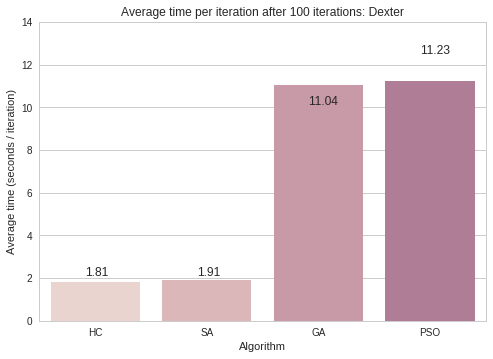

In [88]:
times = [hc_time_dx / 100, sa_time_dx/100, ga_time_dx/100, pso_time_dx/100]

g = sns.barplot(x=['HC', 'SA', 'GA', 'PSO'],y=times,
                palette=sns.cubehelix_palette(8))
plt.title('Average time per iteration after 100 iterations: Dexter')
plt.xlabel('Algorithm')
plt.ylabel('Average time (seconds / iteration)')
plt.ylim((0, 14))
g.text(-0.09, 2.1, str(round(times[0],2)))
g.text(1-0.09, 2.1, str(round(times[1],2)))
g.text(2-0.09, 10.1, str(round(times[2],2)))
g.text(3-0.09, 12.5, str(round(times[3],2)))

In [89]:
# Time test on Dorothea

X_train, y_train, X_test, y_test = load_data('dorothea')
clf = LogisticRegression(C=0.0001, class_weight='balanced')


# SA
start = dft()
run_SA(X_train, y_train, X_test, y_test, max_iter=10, nbr=40, bits=4, nbr_code=3, temp_code=2)
sa_time_d = dft() - start

# HC 
start = dft()
run_HC(X_train, y_train, X_test, y_test, max_iter=10, restart_iter=200, nbr=40, bits=40, nbr_code=3)
hc_time_d = dft() - start

# GA
start = dft()
GA(X_train.shape[1], 10, X_train, y_train, X_test, y_test)
ga_time_d = dft() - start

# PSO
start = dft()
run_pso(150, 10, 0.01, clf)
pso_time_d = dft() - start

DOROTHEA Data:
Training data info: 
800  samples,  100000  features.
78  positve samples,  722  negative samples
-------------------------------
Test data info: 
350  samples.
34  positve samples,  316  negative samples
Initial BER:  0.119880863738
...........Features selected: 54740.0
Final cost 0.08730454207
Iterations run 11 
Final cost  0.08730454207
0.937142857143
(800, 4563)
Initial Cost:  0.236504095309
0.111038719285 1 

37694.0
0.111038719285
0.0952159344751 2 0.08730454207 3 .......Features selected: 56939.0
Final cost 0.08730454207
[ 1.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.
  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  1.
  1.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
Best Result: BER, number of feature 
0.0705510052122 36506
Initializing the swarm....
Iteration  1  Initial Best (BER, f1, num_feats, score): ( 0.104709605361 ,  0.645161290323 ,  40114 ,  0.108721005361 )
 Iteration  1  Current Best (BER, f1, num

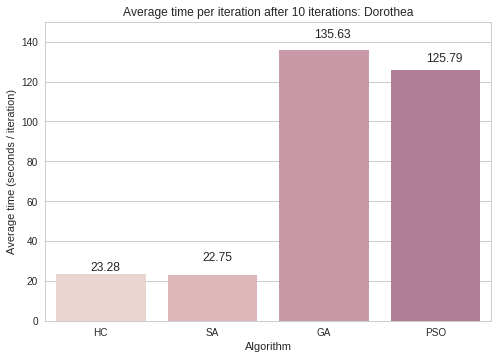

In [96]:
times = [hc_time_d / 10, sa_time_d/10, ga_time_d/10, pso_time_d/10]

g = sns.barplot(x=['HC', 'SA', 'GA', 'PSO'],y=times,
                palette=sns.cubehelix_palette(8))
plt.title('Average time per iteration after 10 iterations: Dorothea')
plt.xlabel('Algorithm')
plt.ylabel('Average time (seconds / iteration)')
plt.ylim((0, 150))
g.text(-0.09, 25, str(round(times[0],2)))
g.text(1-0.09, 30, str(round(times[1],2)))
g.text(2-0.09, 142, str(round(times[2],2)))
g.text(3-0.09, 130, str(round(times[3],2)))